# Placeholder Barplots
These are **NOT** experimental results! This is only the pipeline for the visualization.

In [1]:
from typing import Dict
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from barplots import barplots
from itertools import product
import os

def sample(dictionary:Dict)->Dict:
    return {
        metric: np.random.uniform(
            low=data["min"],
            high=data["max"]
        )
        for metric, data in dictionary.items()
    }

## Metric ranges
The ranges of the fake results and parameters

In [2]:
metrics = {
    "AUROC":{"min":0.5, "max":1, "type":float},
    "AUPRC":{"min":0, "max":1, "type":float},
    "MCC":{"min":-1, "max":1, "type":float},
    "Accuracy":{"min":0.5, "max":1, "type":float},
    "F1Score":{"min":0, "max":1, "type":float},
}
outer_holdouts = 10
inner_holdouts = 3
phase_one_random_samples = 100
phase_two_bo_samples = 100
phase_three_random_samples = 100
phase_three_bo_samples = 100
quality_metric = "MCC"
threshold = 0.01

edge_embedding_methods = [
    "Hadamart", "L1", "L2", "Average"
]
node_embedding_models = [
    "GloVe", "CBOW", "SkipGram"
]
link_prediction_models = [
    "FFNN", "Random Forest", "Logistic Regression"
]
graphs = [
    "PPI", "GGI"
]
run_types = [
    "train", "test"
]
node_parameters = {
    "p":{"min":0.0001, "max":10, "type":float},
    "q":{"min":0.0001, "max":10, "type":float},
    "walk_length":{"min":30, "max":1000, "type":int},
    "embedding_size":{"min":10, "max":200, "type":int},
    "window_size":{"min":1, "max":10, "type":int},
    "iterations":{"min":1, "max":50, "type":int},
    "negative_samples":{"min":1, "max":1000, "type":int},
    "learning_rate":{"min":0.0001, "max":1, "type":float}
}
ffnn_parameters = {
    "length_block_1":{"min":0, "max":10, "type":int},
    "width_block_1":{"min":0, "max":2048, "type":int},
    "learning_rate":{"min":0.0001, "max":1, "type":float}
}

## Creating the fake data of the first phase

In [3]:
datapoints = [
    sample(node_parameters)
    for _ in range(phase_one_random_samples)
]

first_phase = pd.DataFrame([
    {
        **sample(metrics),
        **datapoint,
        "edge_embedding_method":edge_embedding_method,
        "link_prediction_model":"Logistic Regression",
        "graph":graph,
        "run_type":run_type,
        "outer":outer,
        "inner":inner
    }
    for edge_embedding_method in tqdm(
        edge_embedding_methods,
        desc="Computing fake datapoints",
        leave=False
    )
    for datapoint in datapoints
    for outer in range(outer_holdouts)
    for inner in range(inner_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

### Find optimal (fake) edge embedding method for each outer holdout

In [4]:
from scipy.stats import wilcoxon

phase_one_wilcoxon_tests = []

for outer in trange(outer_holdouts):
    for graph in graphs:
        filtered = first_phase[
            (first_phase.run_type=="test") &
            (first_phase.graph==graph) &
            (first_phase.outer==outer)
        ]
        for edge_embedding_method1, edge_embedding_method2 in product(edge_embedding_methods, edge_embedding_methods):
            if edge_embedding_method1 == edge_embedding_method2:
                continue
            results_method1 = filtered[filtered.edge_embedding_method==edge_embedding_method1][quality_metric].values
            results_method2 = filtered[filtered.edge_embedding_method==edge_embedding_method2][quality_metric].values
            stat, p_value = wilcoxon(results_method1, results_method2)
            win, tie, loss = 0, 0, 0
            if p_value >= threshold:
                tie = 1
            elif results_method1.mean() > results_method2.mean():
                win = 1
            else:
                loss = 1
            for method, results in zip(
                (edge_embedding_method1, edge_embedding_method2),
                ((win, tie, loss), (loss, tie, win))
            ):
                for result, value in zip(
                    ("win", "tie", "loss"),
                    results
                ):
                    phase_one_wilcoxon_tests.append({
                        "edge_embedding_method":edge_embedding_method1,
                        "result":result,
                        "count": value,
                        "outer":outer,
                        "graph":graph
                    })

phase_one_best_edge_embedding_method = pd.DataFrame(phase_one_wilcoxon_tests).groupby([
    "graph", "outer", "edge_embedding_method"
]).sum().sort_values(
    "count"
).groupby(["graph", "outer"]).tail(1).reset_index()

phase_one_wilcoxon_tests_sums = pd.DataFrame(phase_one_wilcoxon_tests).groupby([
    "graph", "edge_embedding_method", "result"
]).sum().drop(columns="outer")


# Temporarily replace value with random samples:
phase_one_wilcoxon_tests_sums["count"] = [
    int(value/random_values.sum()*phase_one_wilcoxon_tests_sums["count"].max())
    for random_values in np.random.uniform(size=(len(phase_one_wilcoxon_tests_sums)//3, 3))
    for value in random_values
]

### Plotting the win tie loss

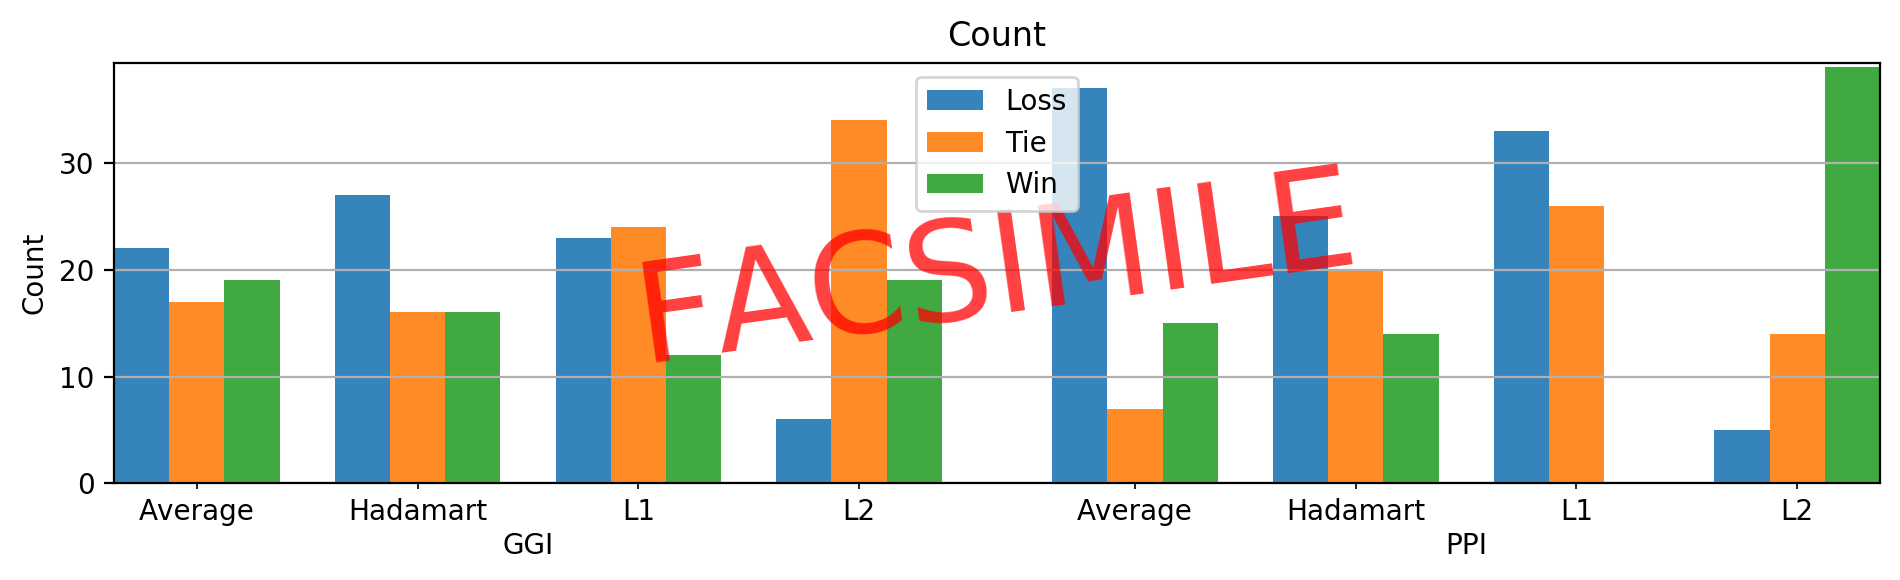

In [5]:
from IPython.display import display, Image
from glob import glob
import matplotlib.pyplot as plt
import shutil

root = "barplots/win_tie_loss_phase_one"
shutil.rmtree(root)
figures, axes = barplots(
    phase_one_wilcoxon_tests_sums,
    groupby=["graph", "edge_embedding_method", "result"],
    show_standard_deviation=False,
    legend_position="upper center",
    path=f"{root}/{{feature}}.jpg",
    facsimile=True,
    height=3
)

## Creating the fake data of the second phase

In [6]:
second_phase = pd.DataFrame([
    {
        **sample(metrics),
        **sample(node_parameters),
        "edge_embedding_method":edge_embedding_method,
        "node_embedding_model":node_embedding_model,
        "link_prediction_model":"Logistic Regression",
        "graph":graph,
        "run_type":run_type,
        "outer":outer,
        "inner":inner
    }
    for edge_embedding_method in tqdm(
        edge_embedding_methods,
        desc="Computing fake datapoints",
        leave=False
    )
    for _ in range(phase_two_bo_samples)
    for outer in range(outer_holdouts)
    for inner in range(inner_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

### Find optimal embedding from second phase

In [7]:
optimal_embeddings = second_phase[second_phase.run_type=="test"].drop(
    columns=["inner"]
).sort_values(
    quality_metric
).groupby(["graph", "outer", "node_embedding_model"]).tail(1)

## Creating the fake data of the third phase

In [8]:
third_phase = pd.DataFrame([
    {
        **sample(metrics),
        **sample(ffnn_parameters),
        **optimal_embeddings[
            (optimal_embeddings.outer==outer) &
            (optimal_embeddings.graph==graph) &
            (optimal_embeddings.node_embedding_model == node_embedding_model)
        ].iloc[0].to_dict(),
        "edge_embedding_method":phase_one_best_edge_embedding_method[
            (phase_one_best_edge_embedding_method.outer==outer) &
            (phase_one_best_edge_embedding_method.graph==graph)
        ].iloc[0]["edge_embedding_method"],
        "link_prediction_model":"FFNN",
        "graph":graph,
        "run_type":run_type,
        "outer":outer,
        "inner":inner
    }
    for _ in trange(phase_three_random_samples + phase_three_bo_samples)
    for outer in range(outer_holdouts)
    for inner in range(inner_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

## Computing all link prediction models performance on outer holdouts

In [9]:
link_prediction_models_results = pd.DataFrame([
    {
        **sample(metrics),
        **optimal_embeddings[
            (optimal_embeddings.outer==outer) &
            (optimal_embeddings.graph==graph) &
            (optimal_embeddings.node_embedding_model == node_embedding_model)
        ].iloc[0].to_dict(),
        "link_prediction_model":model,
        "graph":graph,
        "run_type":run_type,
        "outer":outer
    }
    for model in tqdm(link_prediction_models)
    for outer in range(outer_holdouts)
    for node_embedding_model in node_embedding_models
    for graph in graphs
    for run_type in run_types
])

In [10]:
link_prediction_models_results

,AUROC,AUPRC,MCC,Accuracy,F1Score,p,q,walk_length,embedding_size,window_size,iterations,negative_samples,learning_rate,edge_embedding_method,node_embedding_model,link_prediction_model,graph,run_type,outer
0,0.588674,0.499975,0.999674,0.589039,0.840088,2.408276,3.153076,97.645452,88.206806,1.887712,40.207771,841.845058,0.685705,L1,GloVe,FFNN,PPI,train,0
1,0.588674,0.499975,0.999674,0.589039,0.840088,2.408276,3.153076,97.645452,88.206806,1.887712,40.207771,841.845058,0.685705,L1,GloVe,FFNN,PPI,test,0
2,0.737803,0.331124,0.998864,0.769694,0.232292,9.807500,7.721274,782.056571,40.475946,1.040710,28.685395,298.036764,0.019485,L1,GloVe,FFNN,GGI,train,0
3,0.737803,0.331124,0.998864,0.769694,0.232292,9.807500,7.721274,782.056571,40.475946,1.040710,28.685395,298.036764,0.019485,L1,GloVe,FFNN,GGI,test,0
4,0.604286,0.334456,0.999143,0.674264,0.156309,5.408895,3.072980,551.696167,119.202308,8.606208,49.939924,572.911166,0.310383,Average,CBOW,FFNN,PPI,train,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.774151,0.976231,0.999053,0.614961,0.759297,2.014154,8.237206,303.193276,80.796189,4.924403,37.479254,803.166235,0.143642,L1,CBOW,Logistic Regression,GGI,test,9
356,0.950497,0.595115,0.999367,0.628282,0.635036,1.955757,7.095173,194.427658,58.228521,3.926356,48.700759,238.261074,0.233215,Average,SkipGram,Logistic Regression,PPI,train,9
357,0.950497,0.595115,0.999367,0.628282,0.635036,1.955757,7.095173,194.427658,58.228521,3.926356,48.700759,238.261074,0.233215,Average,SkipGram,Logistic Regression,PPI,test,9
358,0.909010,0.303770,0.997536,0.729427,0.688131,8.971865,7.182812,727.769153,31.068984,5.403578,15.709752,134.428932,0.567997,L2,SkipGram,Logistic Regression,GGI,train,9


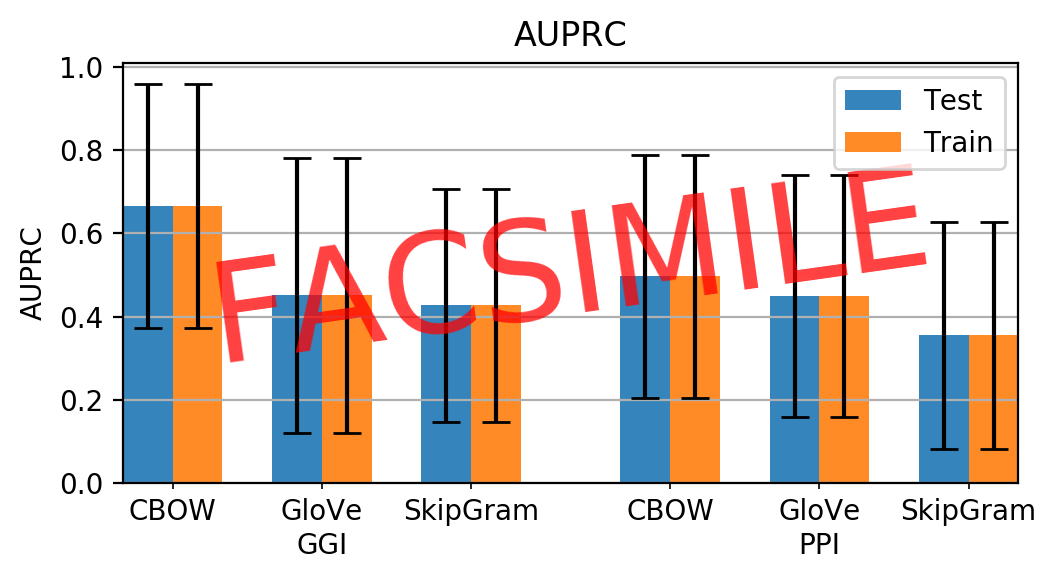

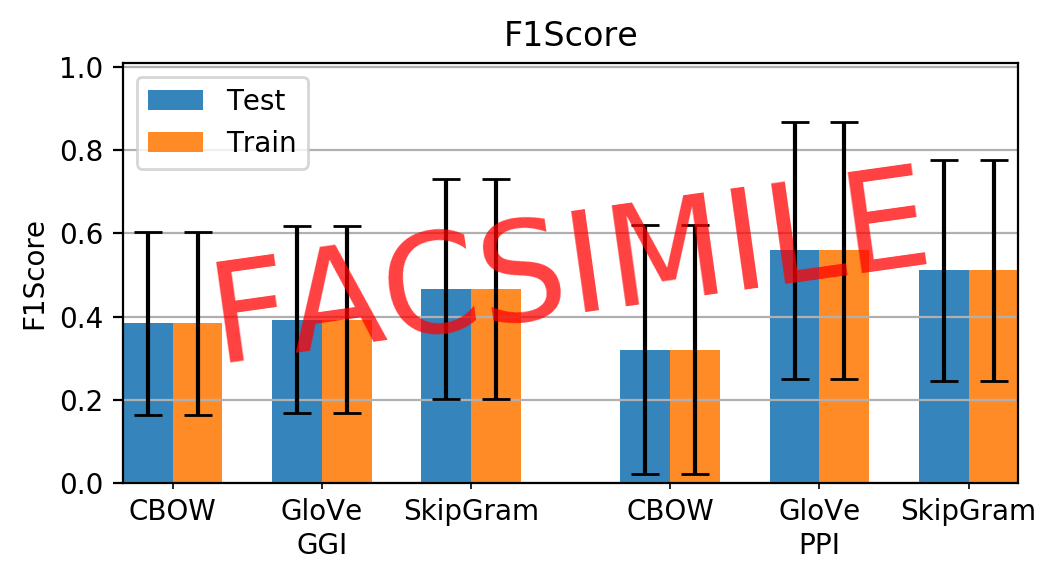

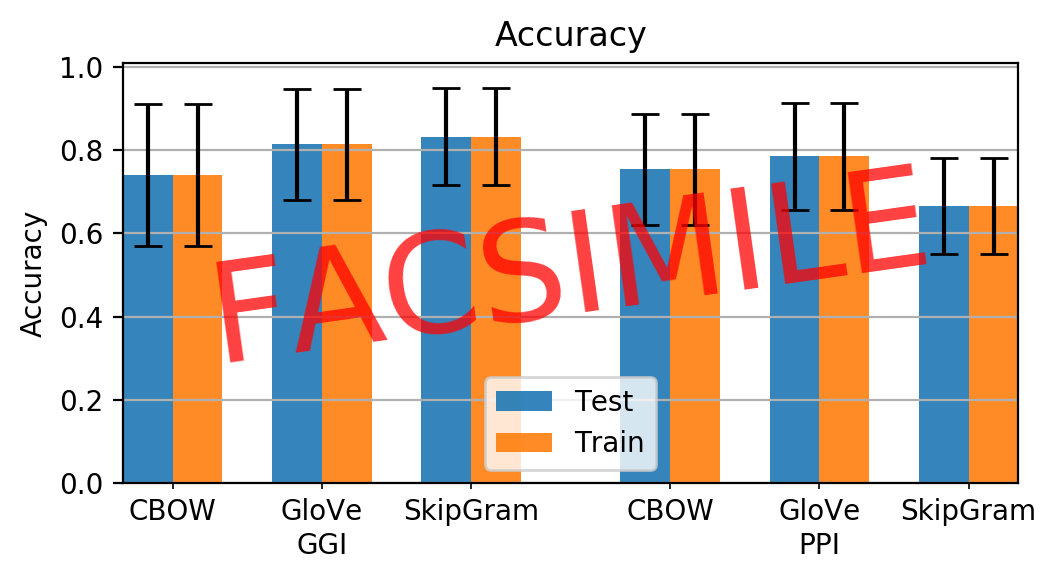

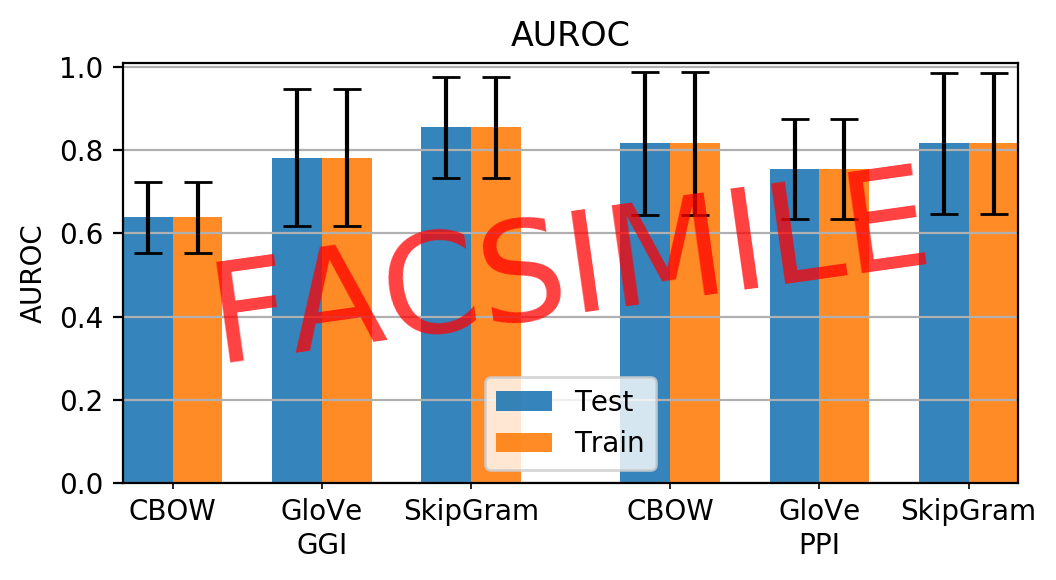

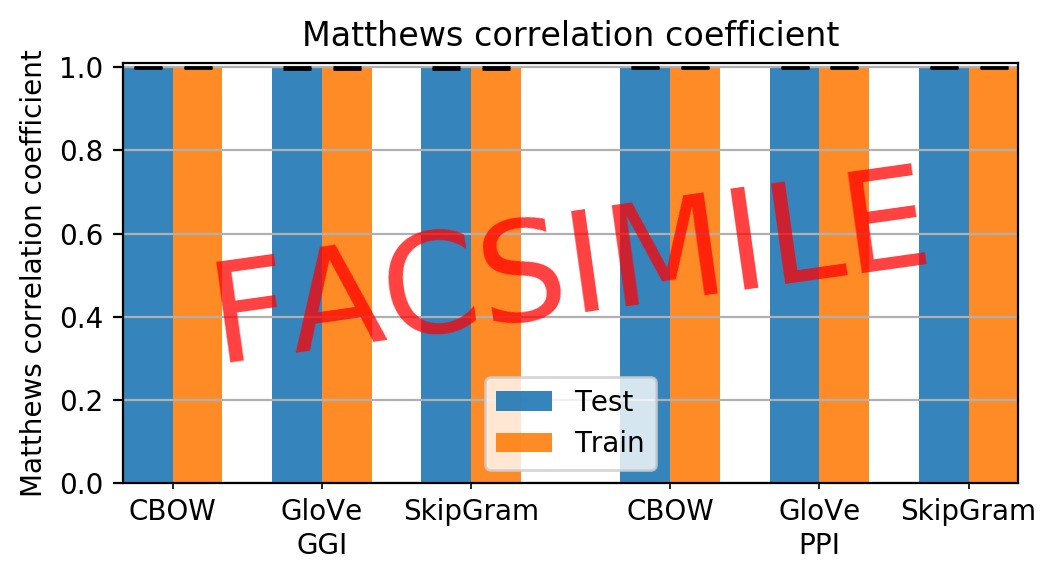

In [12]:
root = "barplots/node_embedding"

if os.path.exists(root):
    shutil.rmtree(root)

groups = ["graph", "node_embedding_model", "run_type"]
figures, axes = barplots(
    link_prediction_models_results[groups+list(metrics.keys())],
    groupby=groups,
    path=f"{root}/{{feature}}.jpg",
    facsimile=True,
    height=3
)

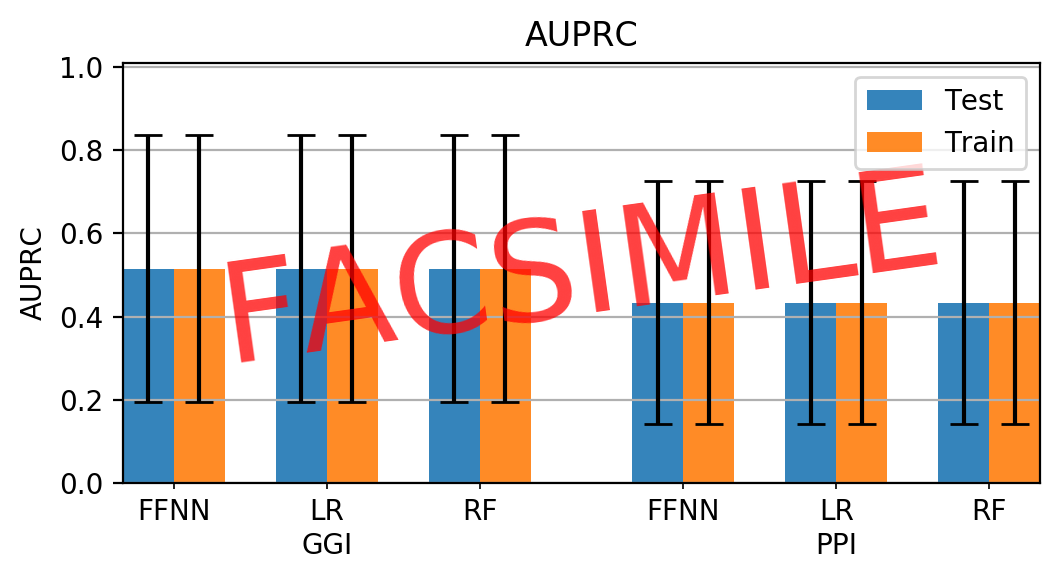

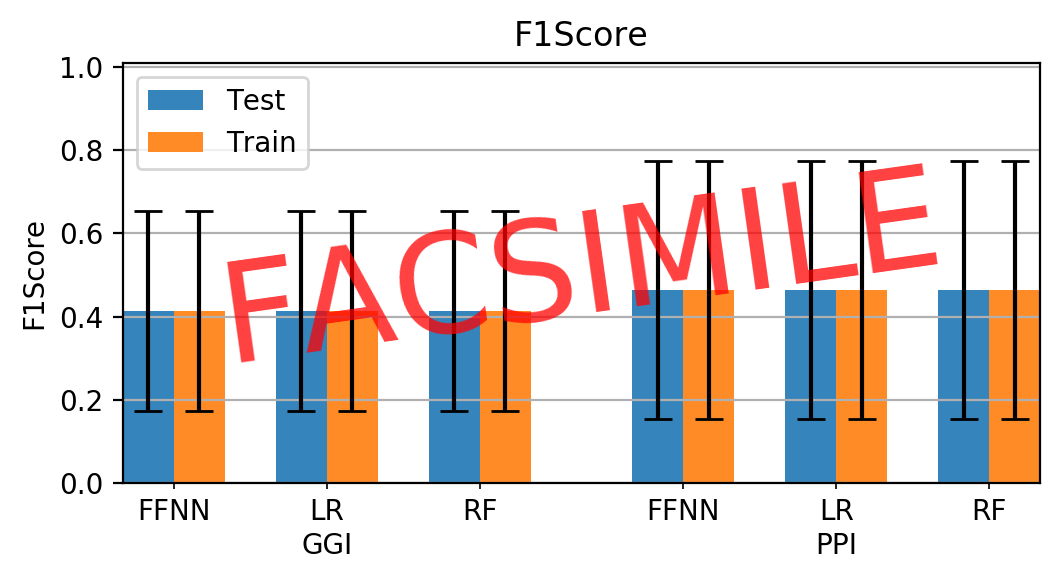

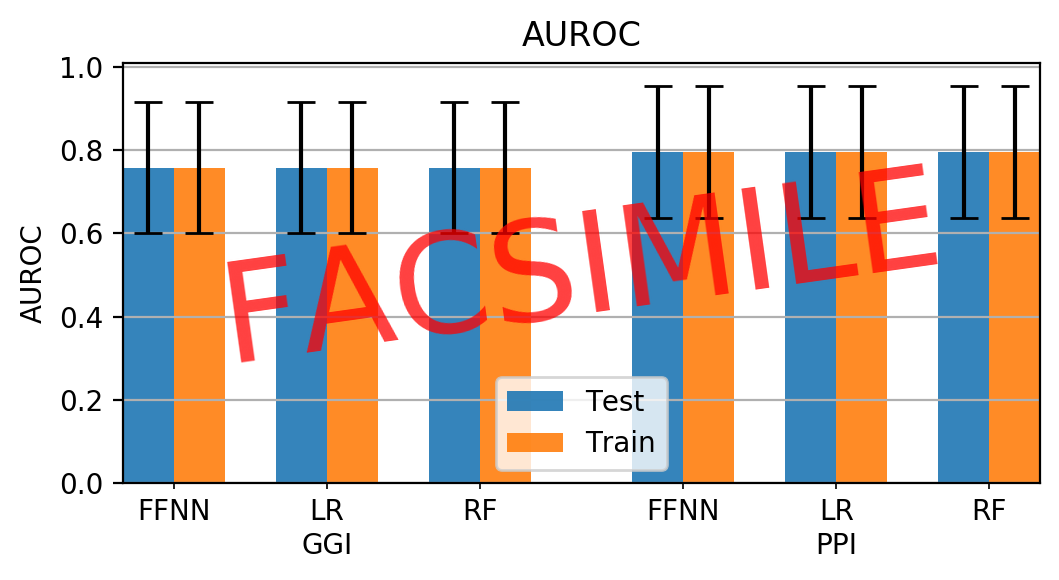

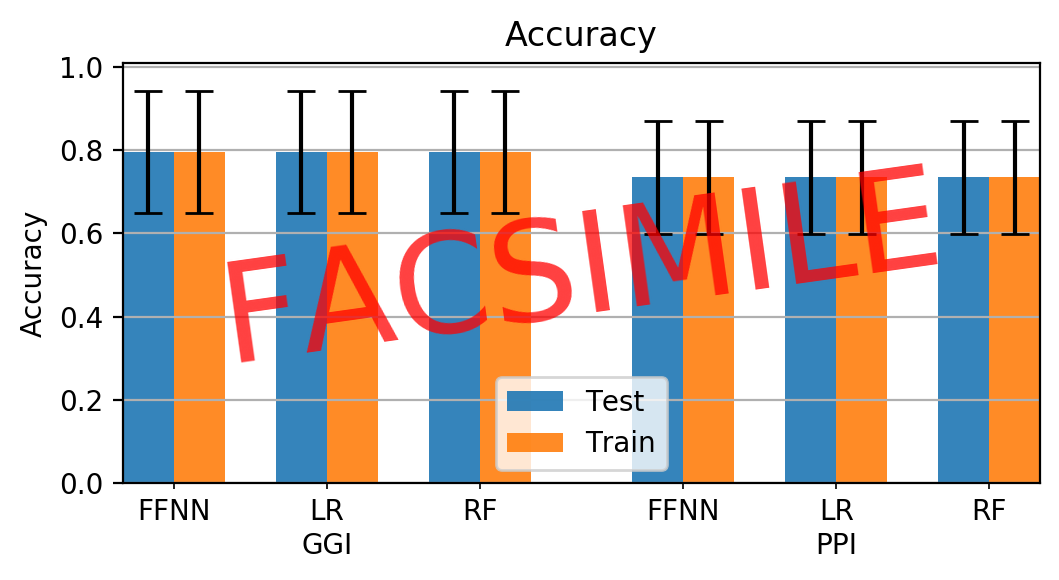

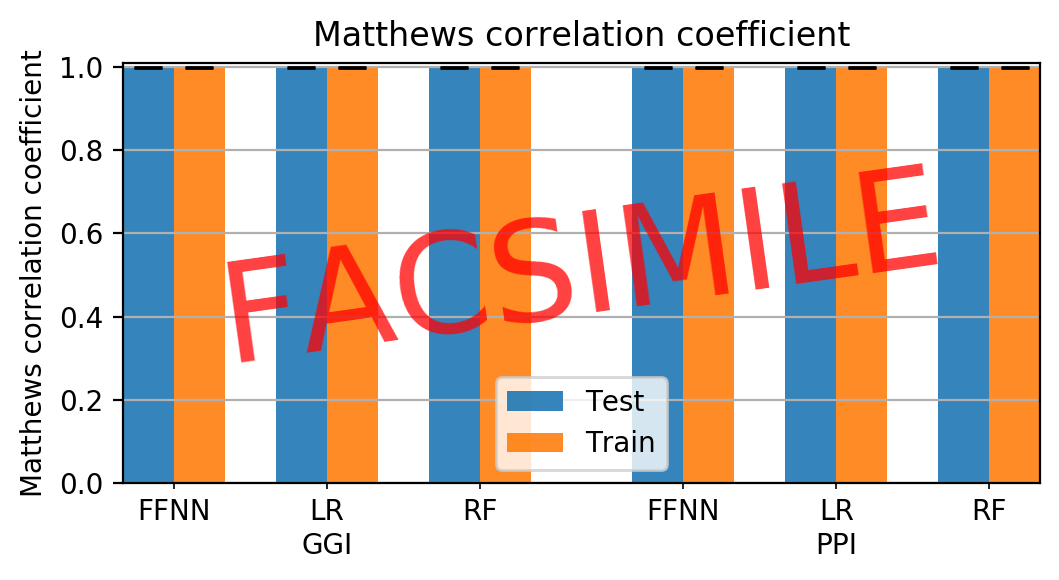

In [21]:
root = "barplots/link_prediction"

if os.path.exists(root):
    shutil.rmtree(root)

groups = ["graph", "link_prediction_model", "run_type"]
figures, axes = barplots(
    link_prediction_models_results[groups+list(metrics.keys())],
    groupby=groups,
    path=f"{root}/{{feature}}.jpg",
    facsimile=True,
    height=3,
    custom_defaults={
        "LR":["Logistic regression"],
        "RF":["Random Forest"],
    }
)